In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date
# import proplot as pplt
import ultraplot as uplt
import sys
import os

# --- Correctly configure paths from within the 'examples' directory ---
# Get the project root directory (which is the parent of the current 'examples' directory)
project_root = os.path.dirname(os.getcwd())

# Add the path to the legacy Oliver code so Python can find it
legacy_code_dir = os.path.join(project_root, 'tests', 'data', 'legacy')
sys.path.append(legacy_code_dir)

# Now we can import everything
import marineHeatWaves as oliver_mhw
from mhw3d import bipolarMhwToolBox as ben_mhw

In [2]:
def generate_synthetic_data():
    """
    Generates a synthetic temperature time series based on the example
    in the ecjoliver/marineHeatWaves README.
    """
    # Create time vector
    t_start = date(1982, 1, 1).toordinal()
    t_end = date(2013, 12, 31).toordinal()
    time = np.arange(t_start, t_end + 1)

    # Create synthetic temperature series
    temp = 15. * np.ones(len(time))
    temp += 5. * np.cos(2 * np.pi * (time - 150) / 365.25) # Seasonal cycle
    temp += 0.2 * (time - time[0]) / (time[-1] - time[0]) # Trend
    temp += 0.5 * np.random.randn(len(time)) # Noise
    
    # Add three MHWs
    temp[1000:1050] += 4.0
    temp[4000:4100] += 3.0
    temp[8000:8050] += 5.0

    # Convert ordinal time to datetime64 for xarray/pandas
    time_datetime = np.array([date.fromordinal(t) for t in time]).astype('datetime64[ns]')

    return time_datetime, temp

## First we check that the detection algorithms produce exactly the same results (applying the benMHW detection to the Oliver thresholds)

In [3]:
# 1. Generate the data
time, temp = generate_synthetic_data()

# 2. Run the original Oliver code
t_ordinal = np.array([pd.to_datetime(t).to_pydatetime().toordinal() for t in time])
expected_events, expected_clim = oliver_mhw.detect(t_ordinal, temp)
expected_df = pd.DataFrame(expected_events)

# 3. Prepare input for YOUR toolbox
ssta = temp - expected_clim['seas']
severity = ssta / (expected_clim['thresh'] - expected_clim['seas'])

# 4. Create the xarray.Dataset for your code
ds_input_1d = xr.Dataset(
    data_vars={'ssta': (('time',), ssta), 'severity': (('time',), severity)},
    coords={'time': time}
)
ds_input = ds_input_1d.expand_dims(['lat', 'lon'])

# 5. Run YOUR code
ds_actual_events = ben_mhw.calculate_MHWs_metrics(ds_input)

# 6. Format your results into a clean DataFrame
ds_actual_events = ds_actual_events.squeeze(drop=True).dropna('event', how='all')
actual_df = pd.DataFrame({
    'date_start': ds_actual_events['date_start'].values,
    'date_end': ds_actual_events['date_end'].values,
    'date_peak': ds_actual_events['date_peak'].values,
    'duration': ds_actual_events['duration'].values,
    'intensity_max': ds_actual_events['intensity_max'].values,
    'intensity_mean': ds_actual_events['intensity_mean'].values,
    'intensity_cumulative': ds_actual_events['intensity_cumul'].values,
})


In [4]:
# Select only the columns we want to compare
columns_to_compare = actual_df.columns.tolist()

print("--- Expected Events (Oliver Method) ---")
display(expected_df[columns_to_compare])

print("\n--- Actual Events (Ben-MHW Method) ---")
display(actual_df)

--- Expected Events (Oliver Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-10-21,50,4.932950,3.742089,187.104445
1,1992-12-14,1993-03-23,1992-12-28,100,3.982021,2.735711,273.571096
2,2003-11-27,2004-01-15,2003-12-30,50,5.872529,4.718433,235.921631



--- Actual Events (Ben-MHW Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-10-21,50.0,4.932950,3.742089,187.104445
1,1992-12-14,1993-03-23,1992-12-28,100.0,3.982021,2.735711,273.571096
2,2003-11-27,2004-01-15,2003-12-30,50.0,5.872529,4.718433,235.921631


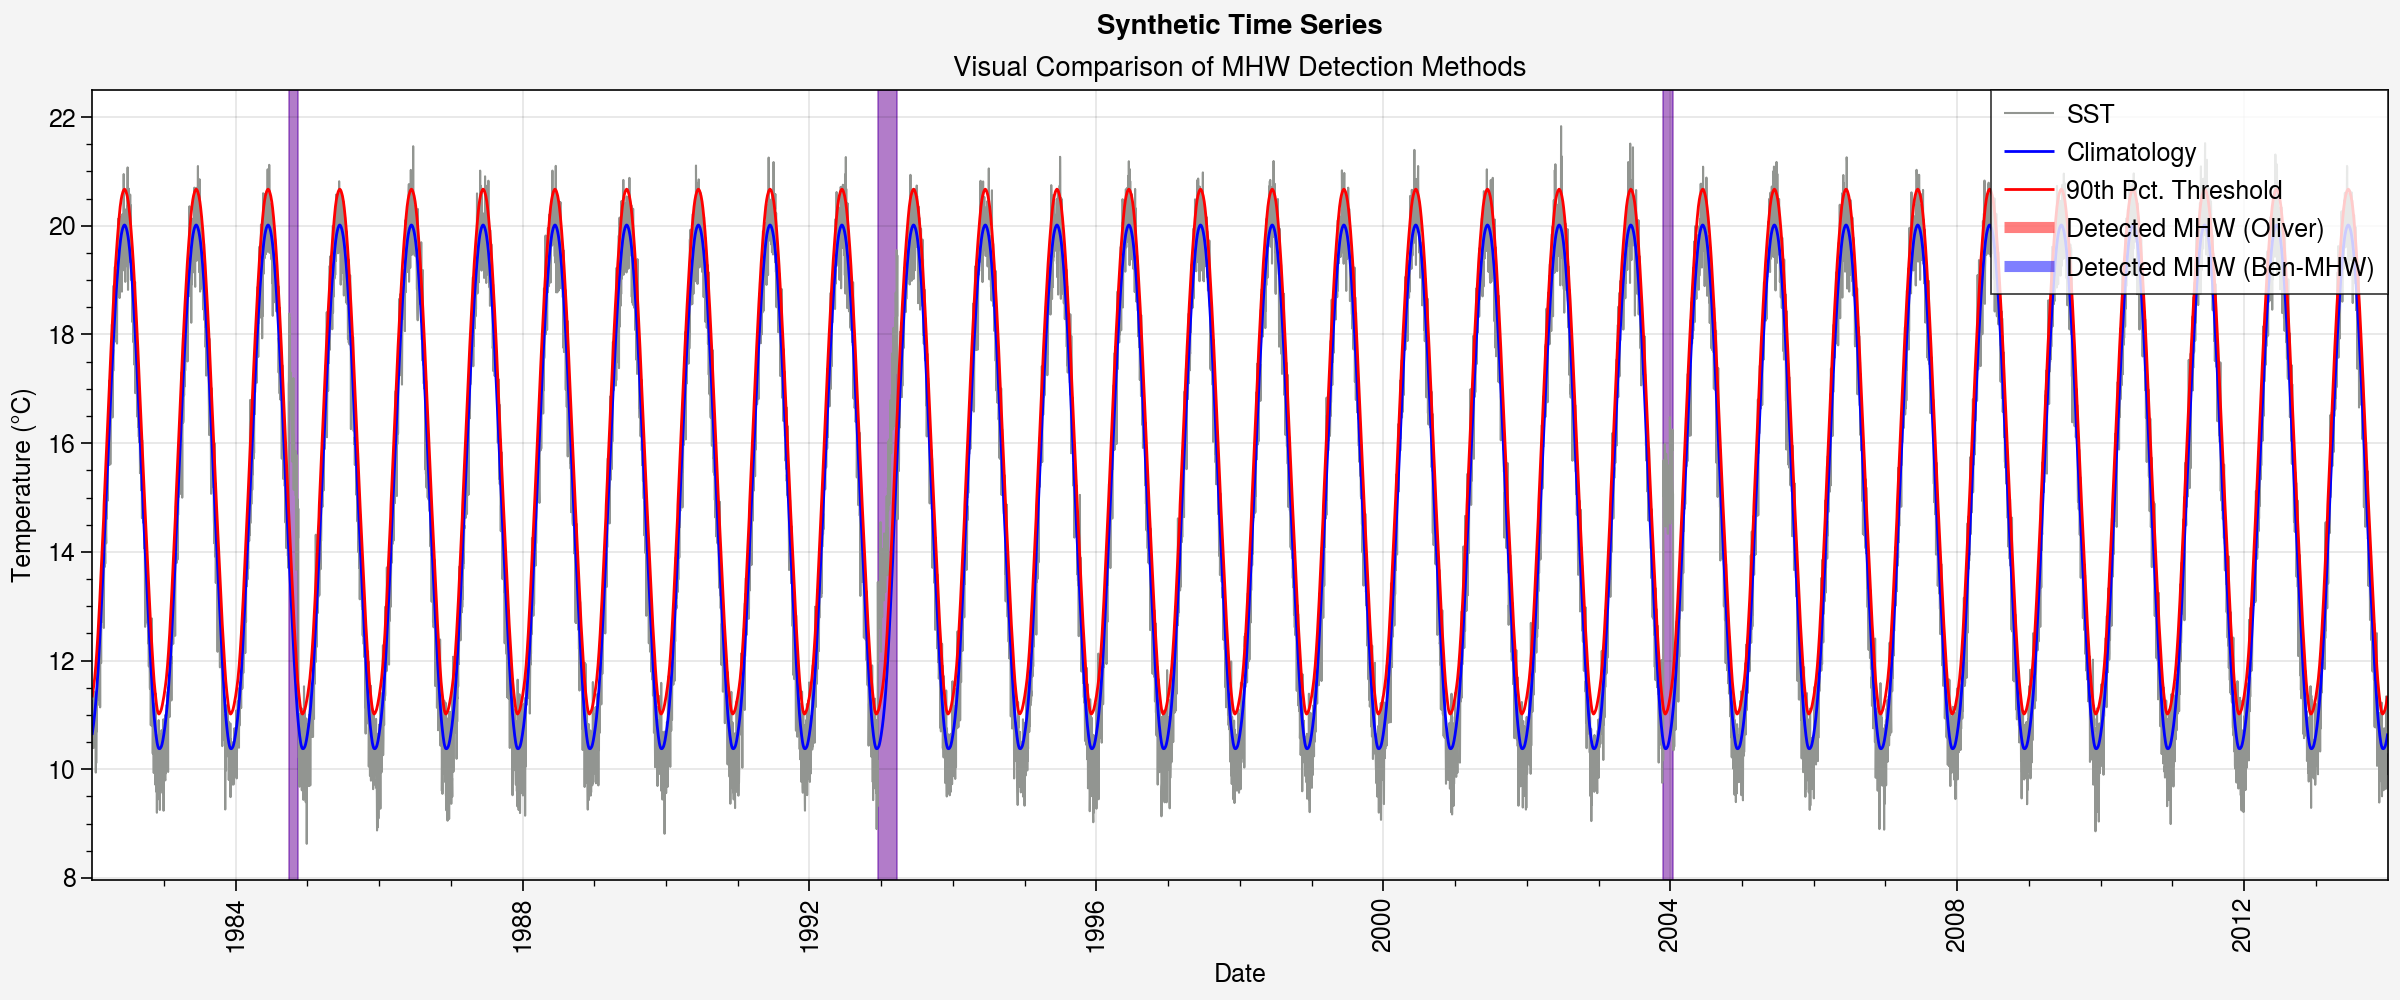

In [5]:
# Create a figure and axes for the plot
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

# Plot the full temperature time series, climatology, and threshold
ax.plot(time, temp, color='gray', lw=0.75, label='SST')
ax.plot(time, expected_clim['seas'], color='blue', lw=1, label='Climatology')
ax.plot(time, expected_clim['thresh'], color='red', lw=1, label='90th Pct. Threshold')

# Highlight the detected MHWs from both methods
# Use different colors with transparency to see the overlap
for i, event in expected_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='red', alpha=0.3)

for i, event in actual_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='blue', alpha=0.3)

# Add clear legend entries
ax.plot([], [], color='red', lw=4, alpha=0.5, label='Detected MHW (Oliver)')
ax.plot([], [], color='blue', lw=4, alpha=0.5, label='Detected MHW (Ben-MHW)')

# Format the plot
ax.format(
    title='Visual Comparison of MHW Detection Methods',
    xlabel='Date',
    ylabel='Temperature (°C)',
    suptitle='Synthetic Time Series'
)
ax.legend(ncols=1, loc='upper right')

uplt.show()

## Then compare the climatologies and thresholds between the two codes:

Calculating 366-day climatology using the ben-mhw toolbox...
Calculation complete.
Summarizing the Oliver code's daily output...
Summarizing complete.


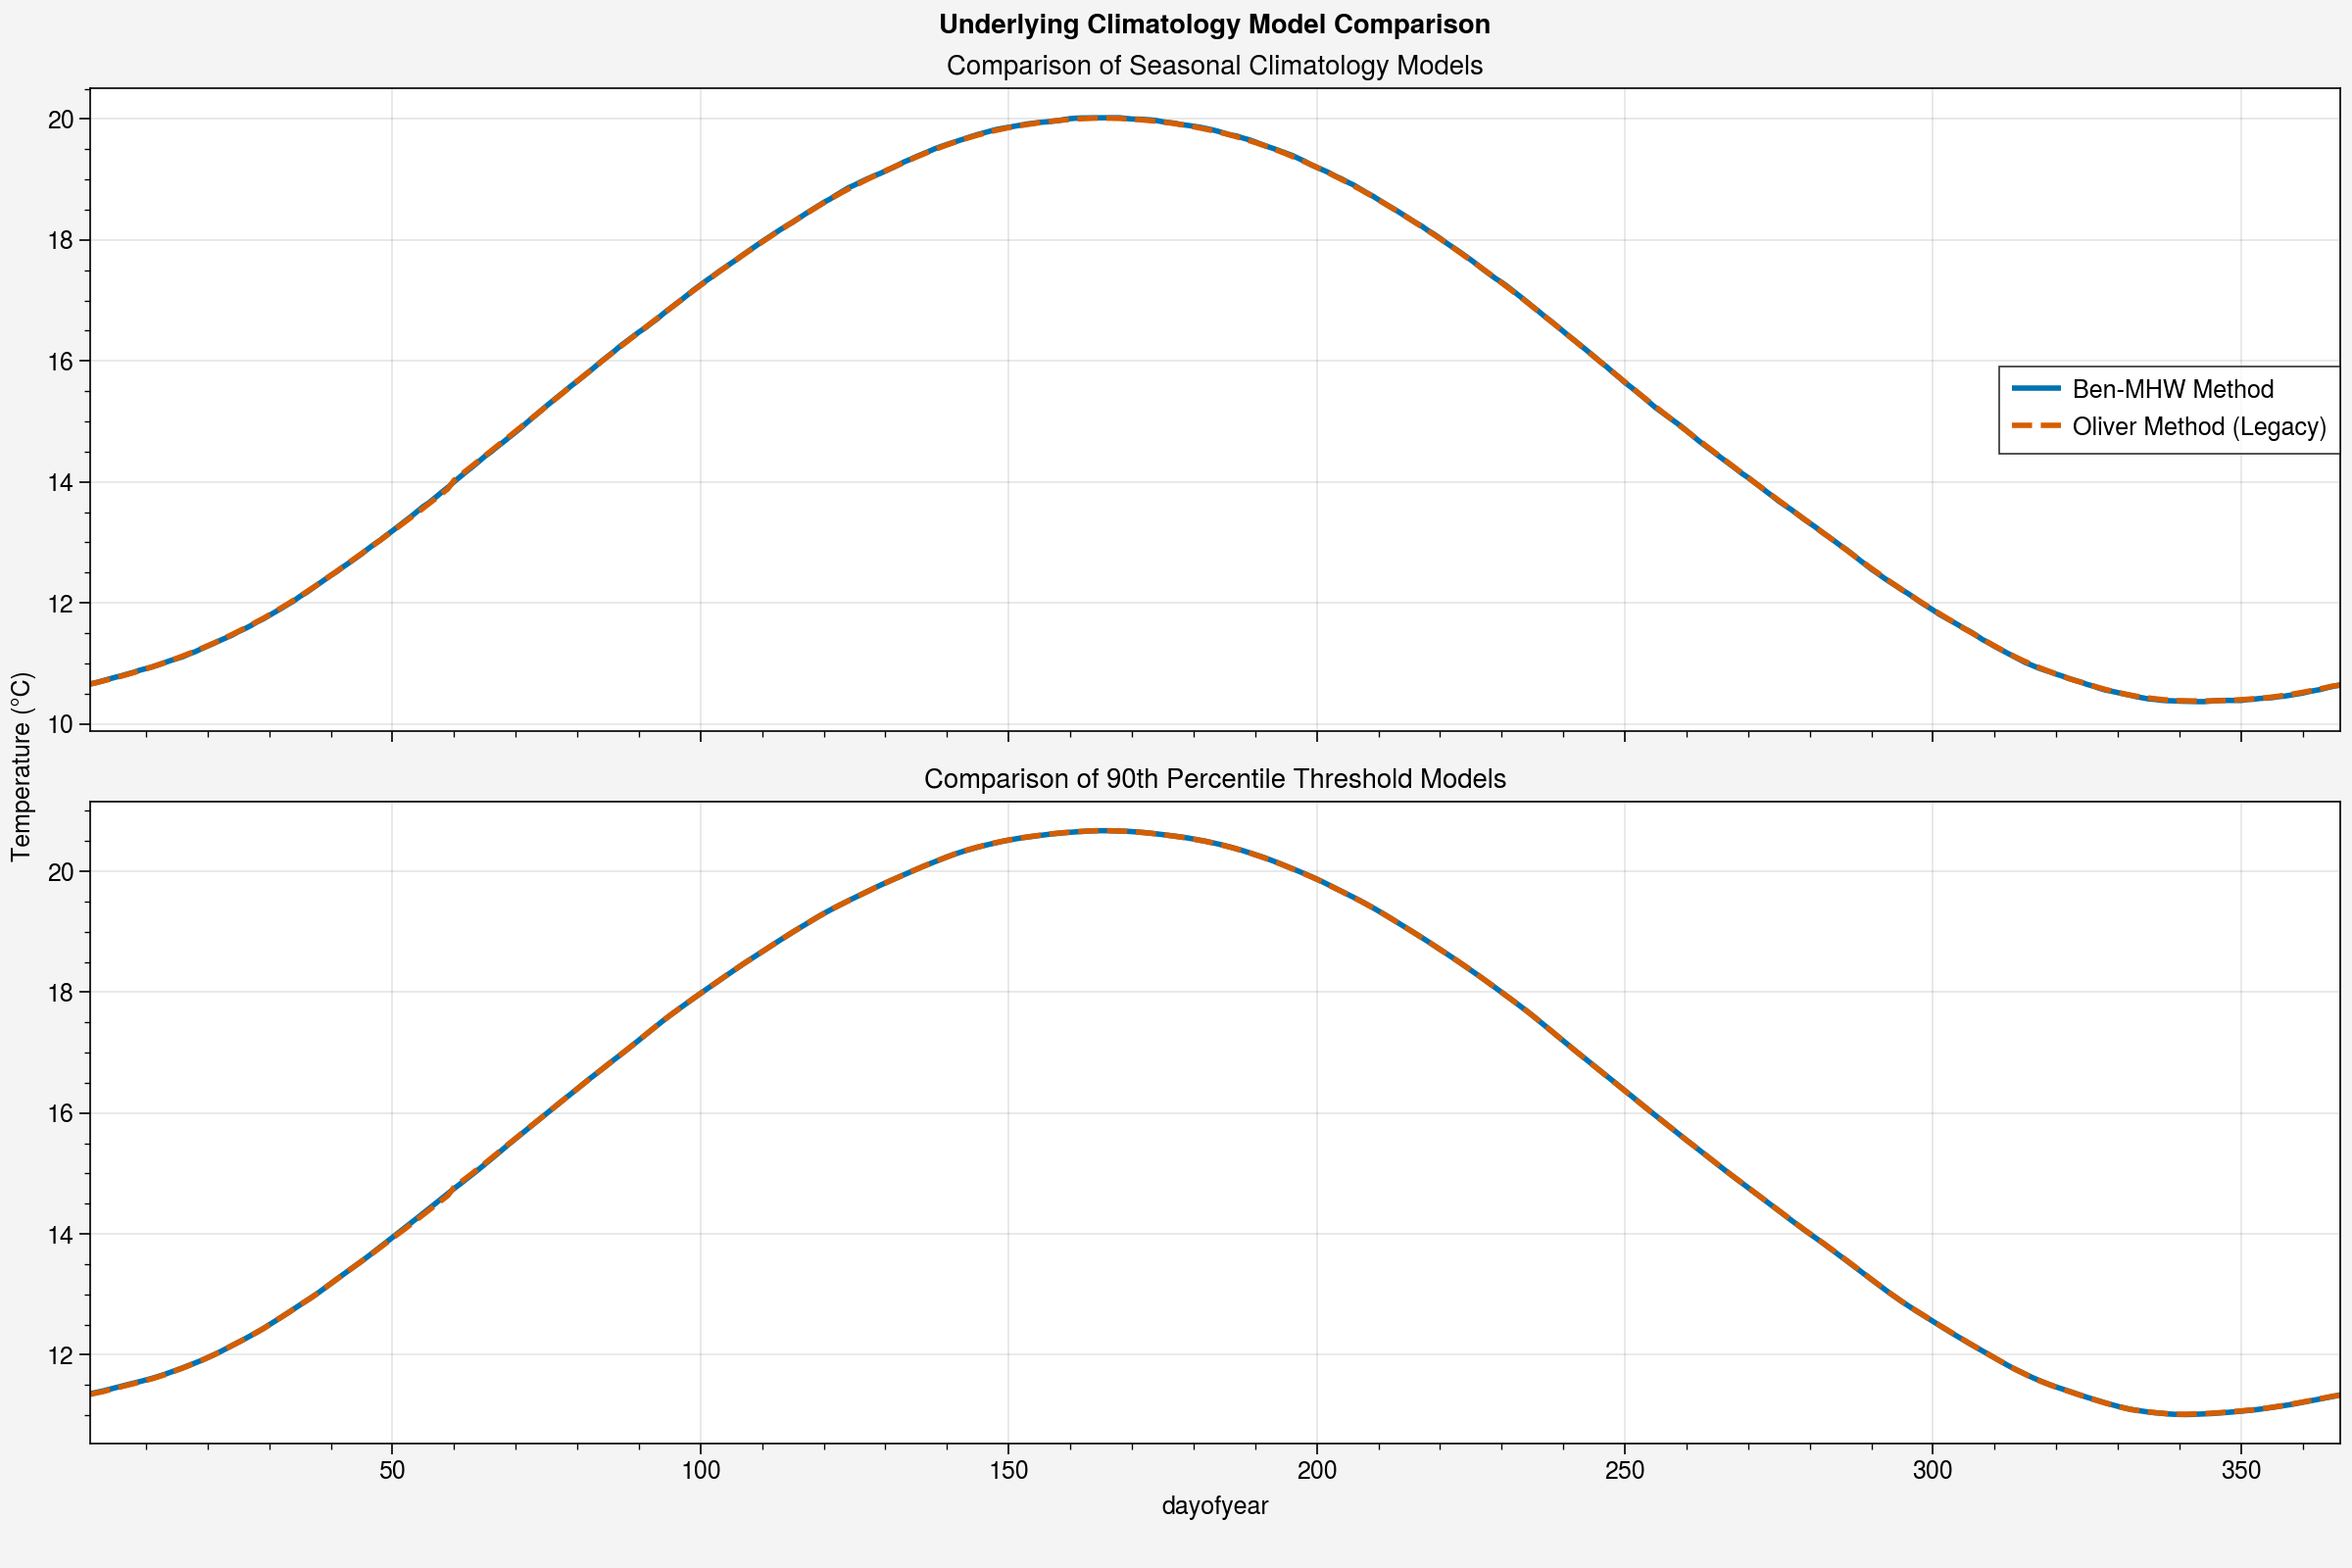

In [6]:
# --- Cell 6: The Correct Climatology Comparison ---

# 1. Calculate the 366-day summary climatology with YOUR ben-mhw code
print("Calculating 366-day climatology using the ben-mhw toolbox...")
ds_for_clim = xr.Dataset(
    data_vars={'temp': (('time',), temp)},
    coords={'time': time}
).expand_dims(['lat', 'lon'])

actual_seas_summary = ben_mhw.smoothedClima_mhw(ds_for_clim.temp).squeeze()
actual_thresh_summary = ben_mhw.smoothedThresh_mhw(ds_for_clim.temp).squeeze()
print("Calculation complete.")


# 2. Convert the Oliver code's DAILY output into a 366-day summary
print("Summarizing the Oliver code's daily output...")
# Create a temporary xarray.DataArray from the Oliver code's daily output
oliver_daily_clim = xr.DataArray(
    expected_clim['seas'], dims=['time'], coords={'time': time}
)
oliver_daily_thresh = xr.DataArray(
    expected_clim['thresh'], dims=['time'], coords={'time': time}
)

# Now, group by day-of-year and average to create the 366-day summary
expected_seas_summary = oliver_daily_clim.groupby('time.dayofyear').mean()
expected_thresh_summary = oliver_daily_thresh.groupby('time.dayofyear').mean()
print("Summarizing complete.")


# 3. Create the definitive comparison plot
fig, axs = uplt.subplots(nrows=2, figsize=(12, 8), tight=True, sharex=True)

# Plot Seasonal Climatologies
axs[0].plot(actual_seas_summary, lw=2, label='Ben-MHW Method')
axs[0].plot(expected_seas_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[0].format(
    title='Comparison of Seasonal Climatology Models',
    ylabel='Temperature (°C)'
)
axs[0].legend(ncols=1, loc='best')

# Plot 90th Percentile Thresholds
axs[1].plot(actual_thresh_summary, lw=2, label='Ben-MHW Method')
axs[1].plot(expected_thresh_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[1].format(
    title='Comparison of 90th Percentile Threshold Models',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)

fig.format(suptitle='Underlying Climatology Model Comparison')
uplt.show()

In [7]:
actual_seas_summary

<xarray.DataArray 'temp' (dayofyear: 366)> Size: 3kB
array([10.65980258, 10.68241326, 10.71052927, 10.73858018, 10.7677272 ,
       10.79238327, 10.82229918, 10.84978466, 10.88553174, 10.91156016,
       10.93969649, 10.9730474 , 11.00993277, 11.04518507, 11.07665188,
       11.10903558, 11.15304483, 11.19120818, 11.23977227, 11.28517894,
       11.32861278, 11.37570739, 11.42078557, 11.46595928, 11.52271382,
       11.56864792, 11.62100652, 11.6821601 , 11.73101071, 11.7898309 ,
       11.84666433, 11.90901534, 11.97200715, 12.0310277 , 12.10622507,
       12.16684157, 12.23872173, 12.30972173, 12.38361861, 12.45230479,
       12.51750785, 12.5934268 , 12.66305431, 12.73627029, 12.80834192,
       12.88859311, 12.96463994, 13.03360755, 13.11405199, 13.18896614,
       13.26749098, 13.34535811, 13.42497708, 13.50770355, 13.59106744,
       13.65902162, 13.74325321, 13.82792896, 13.90838829, 13.99990174,
       14.08403344, 14.16877685, 14.24973101, 14.33402099, 14.42142213,
       14.49554909, 14.5798356 , 14.6583022 , 14.74026536, 14.8217873 ,
       14.90518878, 14.99543756, 15.08060743, 15.16736723, 15.25470474,
       15.3381585 , 15.42052307, 15.50097613, 15.58583062, 15.66396984,
       15.74475786, 15.82738292, 15.91307287, 15.99938144, 16.07907666,
       16.15937166, 16.2467895 , 16.32232579, 16.39675495, 16.47557314,
       16.54317476, 16.62230748, 16.69619816, 16.78436071, 16.86225676,
       16.94025226, 17.01766814, 17.09997846, 17.18186735, 17.25611964,
...
       13.99339472, 13.91483111, 13.83550372, 13.75894868, 13.678504  ,
       13.60835046, 13.54047407, 13.46351162, 13.38743545, 13.31549062,
       13.24553014, 13.16504633, 13.09566724, 13.02109637, 12.94583684,
       12.87573196, 12.7963766 , 12.7139976 , 12.63511772, 12.55596278,
       12.48615136, 12.41256928, 12.34428852, 12.28040784, 12.21139372,
       12.1502671 , 12.08051412, 12.00770047, 11.94402737, 11.87937261,
       11.81161991, 11.75407941, 11.69554524, 11.6399871 , 11.57703492,
       11.52599024, 11.46223489, 11.3939063 , 11.33948345, 11.28078004,
       11.22565474, 11.17154912, 11.11843498, 11.06364505, 11.01180288,
       10.96888394, 10.92648078, 10.88982337, 10.85832732, 10.82040869,
       10.78787355, 10.74883329, 10.71779139, 10.68938712, 10.65083448,
       10.62340936, 10.58690709, 10.55656278, 10.53723373, 10.51419118,
       10.49239285, 10.47176745, 10.44738279, 10.42816554, 10.41074576,
       10.40225265, 10.38889542, 10.38164126, 10.37879356, 10.37371252,
       10.37082276, 10.36745678, 10.36629405, 10.3658045 , 10.37388819,
       10.38306047, 10.38639336, 10.38595882, 10.38535911, 10.38511602,
       10.39995183, 10.40489122, 10.41825269, 10.42529509, 10.43116863,
       10.44708262, 10.45596639, 10.47389433, 10.49026691, 10.5075574 ,
       10.53132709, 10.55097538, 10.56987902, 10.59720054, 10.62017235,
       10.64264647])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [8]:
expected_seas_summary

<xarray.DataArray (dayofyear: 366)> Size: 3kB
array([10.65622736, 10.6808299 , 10.70616401, 10.73233777, 10.75978688,
       10.78710929, 10.81541717, 10.84535876, 10.87648554, 10.90808236,
       10.94003254, 10.97383614, 11.00835566, 11.04462892, 11.08218305,
       11.12053557, 11.16066651, 11.20191225, 11.24393742, 11.28773672,
       11.33278787, 11.37933068, 11.42743207, 11.47650503, 11.52651036,
       11.57755448, 11.63031835, 11.68452742, 11.74000398, 11.79820996,
       11.85676703, 11.91768283, 11.9802933 , 12.04406226, 12.10963445,
       12.1757869 , 12.24367439, 12.31222339, 12.38170186, 12.45236679,
       12.52349116, 12.59601828, 12.66828063, 12.74140156, 12.81373517,
       12.88582416, 12.95855821, 13.03216203, 13.10673844, 13.1826397 ,
       13.25798326, 13.33326593, 13.40928067, 13.48596766, 13.56437275,
       13.64358154, 13.72325061, 13.80359417, 13.88408593, 14.02484956,
       14.1057919 , 14.187503  , 14.26893981, 14.35029045, 14.43094764,
       14.51166686, 14.5925671 , 14.67373166, 14.75543705, 14.83722923,
       14.91947787, 15.0015988 , 15.0836995 , 15.16587973, 15.24853379,
       15.33227242, 15.4162072 , 15.49975304, 15.58308927, 15.66580265,
       15.74817928, 15.83062546, 15.91271   , 15.99445452, 16.07516321,
       16.15550166, 16.235358  , 16.31449176, 16.39343357, 16.47193224,
       16.55028374, 16.62851312, 16.70609663, 16.78399501, 16.8618711 ,
       16.93988995, 17.01794622, 17.09568427, 17.17270284, 17.24855995,
...
       13.99159686, 13.91596379, 13.8404909 , 13.76519424, 13.69025473,
       13.61528178, 13.54017212, 13.4656599 , 13.39160507, 13.31783947,
       13.24452479, 13.17068619, 13.09551682, 13.01987105, 12.94399485,
       12.86816402, 12.79230401, 12.71734096, 12.64290727, 12.56901389,
       12.49630824, 12.42406731, 12.35245113, 12.28262827, 12.21391802,
       12.14614566, 12.07968962, 12.01453649, 11.95038053, 11.8867221 ,
       11.82410565, 11.76144123, 11.69908589, 11.63792272, 11.57720205,
       11.51747507, 11.45892715, 11.40075896, 11.34305758, 11.28575643,
       11.22981917, 11.17524011, 11.12309089, 11.07374088, 11.0266535 ,
       10.98179709, 10.93865923, 10.89755373, 10.85837064, 10.82068273,
       10.78508267, 10.7505305 , 10.7170154 , 10.68475181, 10.65355421,
       10.62341859, 10.59475213, 10.56745095, 10.5413836 , 10.51637913,
       10.49400341, 10.4734961 , 10.45550095, 10.43971278, 10.42552728,
       10.41309989, 10.40236375, 10.3933135 , 10.38614655, 10.38129291,
       10.37919153, 10.37815934, 10.3778892 , 10.37801196, 10.37896437,
       10.38086898, 10.38375345, 10.38781009, 10.39265066, 10.39858438,
       10.40540865, 10.41230465, 10.42000768, 10.42965462, 10.44144435,
       10.45469838, 10.46926587, 10.48518649, 10.50217777, 10.52056838,
       10.54006047, 10.5599976 , 10.58108994, 10.60342591, 10.62668317,
       10.63254977])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

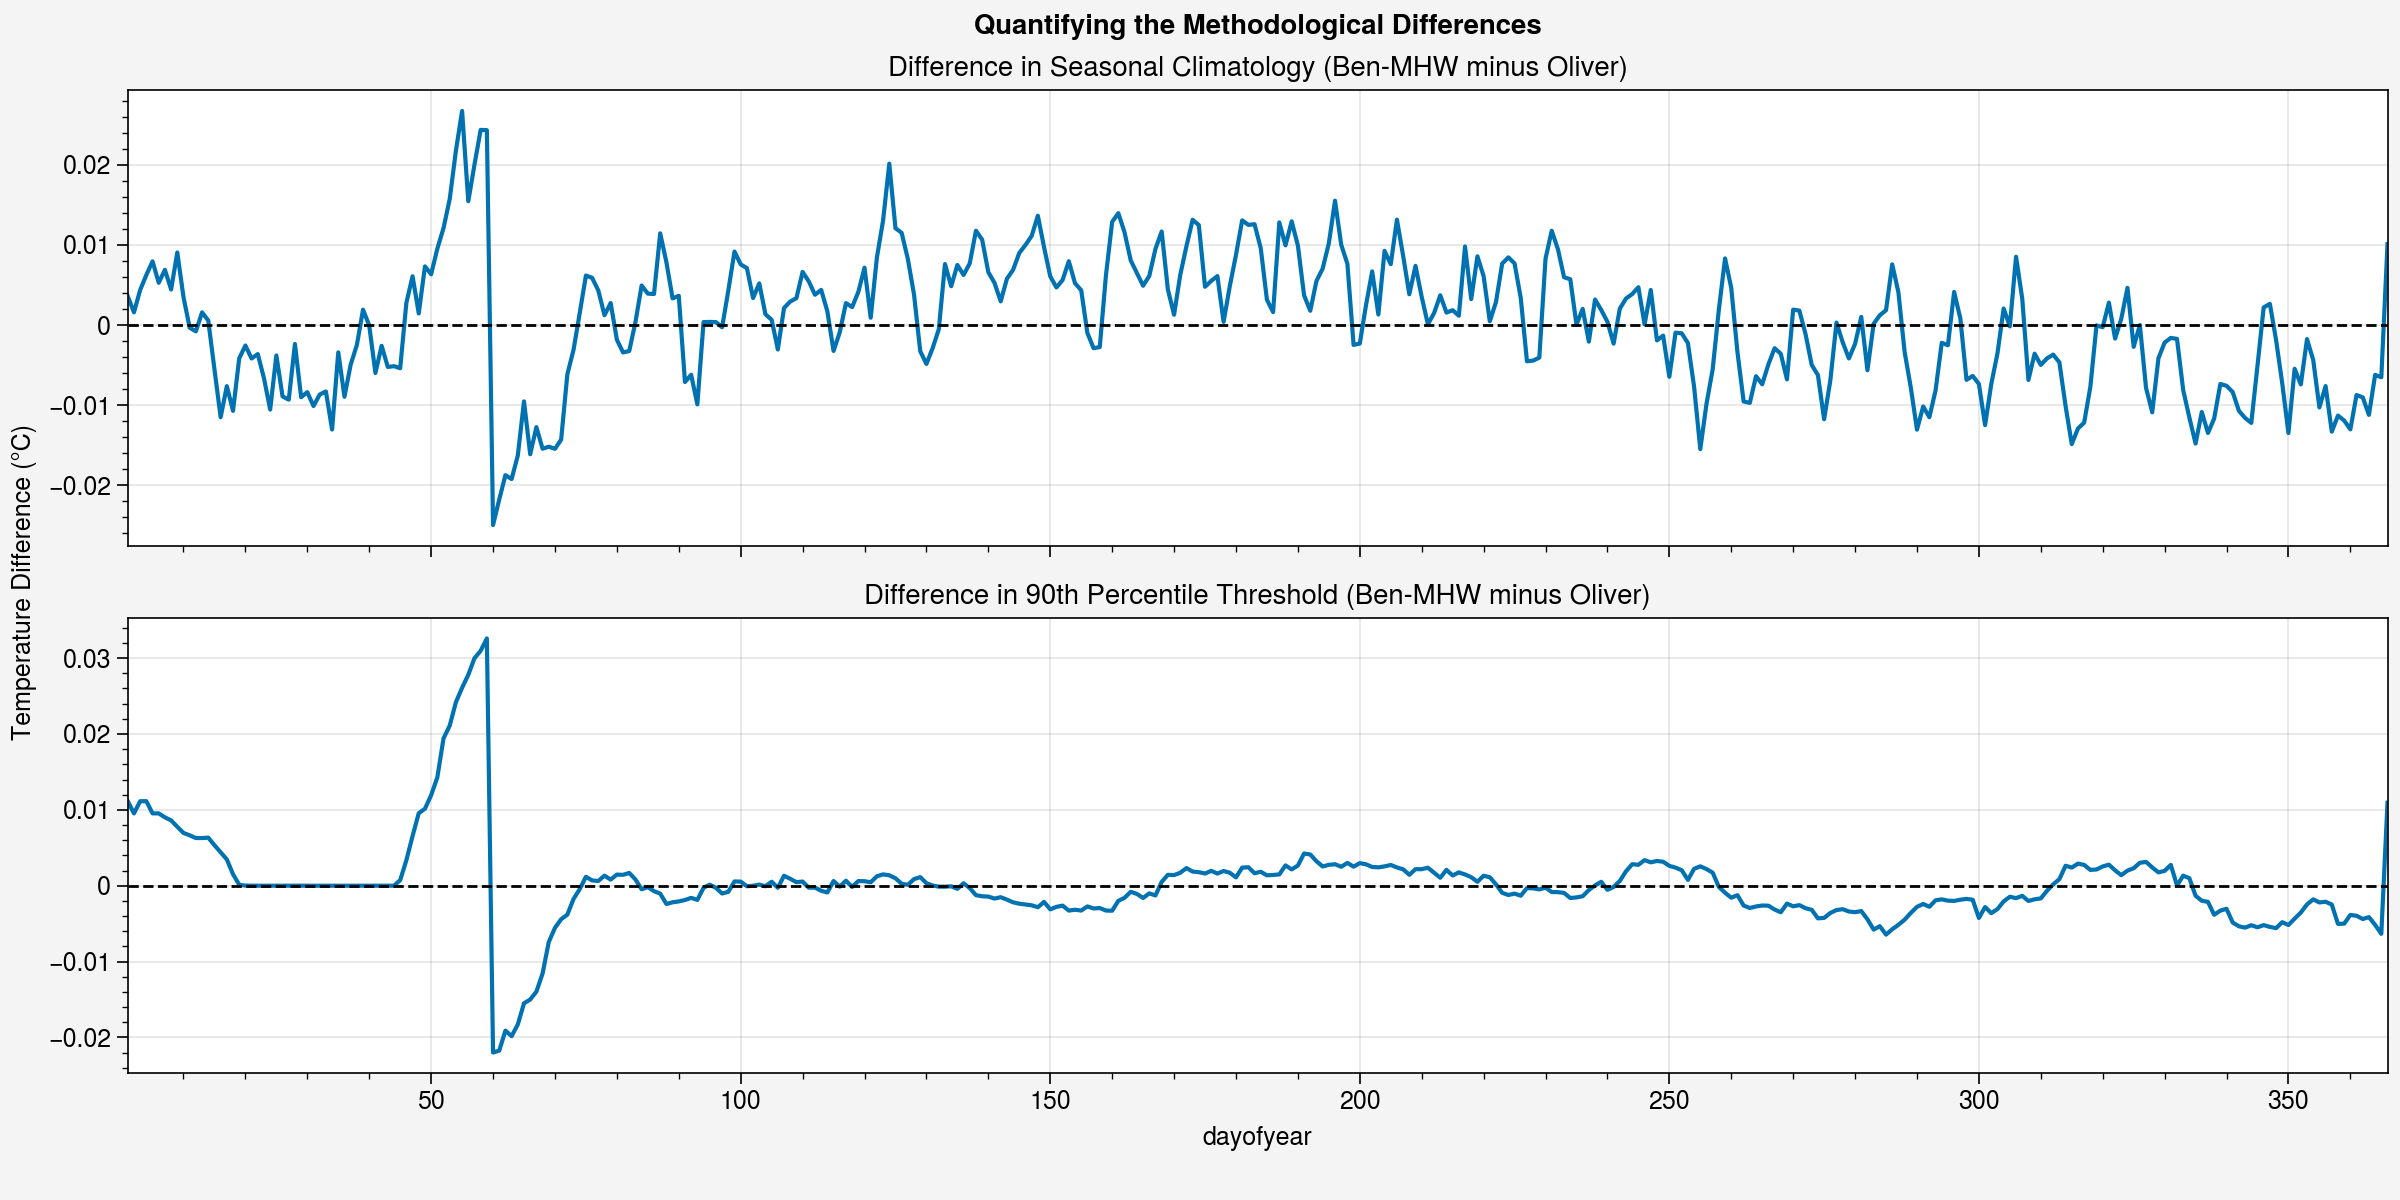

Maximum absolute difference in climatology: 0.0267 °C
Maximum absolute difference in threshold: 0.0326 °C


In [9]:
# --- Cell 7: Numerical Difference Analysis ---

# Calculate the difference between the two climatology models
climatology_difference = actual_seas_summary.values - expected_seas_summary.values

# Calculate the difference between the two threshold models
threshold_difference = actual_thresh_summary.values - expected_thresh_summary.values


# Create a new plot to visualize JUST the difference
fig, axs = uplt.subplots(nrows=2, figsize=(12, 6), tight=True, sharex=True)

# Plot the difference in seasonal climatologies
axs[0].plot(actual_seas_summary.dayofyear, climatology_difference)
axs[0].axhline(0, color='k', linestyle='--', lw=1) # Add a zero line for reference
axs[0].format(
    title='Difference in Seasonal Climatology (Ben-MHW minus Oliver)',
    ylabel='Temperature Difference (°C)'
)

# Plot the difference in 90th percentile thresholds
axs[1].plot(actual_thresh_summary.dayofyear, threshold_difference)
axs[1].axhline(0, color='k', linestyle='--', lw=1)
axs[1].format(
    title='Difference in 90th Percentile Threshold (Ben-MHW minus Oliver)',
    xlabel='Day of Year',
    ylabel='Temperature Difference (°C)'
)

fig.format(suptitle='Quantifying the Methodological Differences')
uplt.show()

# Print the maximum absolute difference to quantify the magnitude
print(f"Maximum absolute difference in climatology: {np.abs(climatology_difference).max():.4f} °C")
print(f"Maximum absolute difference in threshold: {np.abs(threshold_difference).max():.4f} °C")

Calculating RAW (unsmoothed) percentile values for each day-of-year...
Raw value calculation complete.


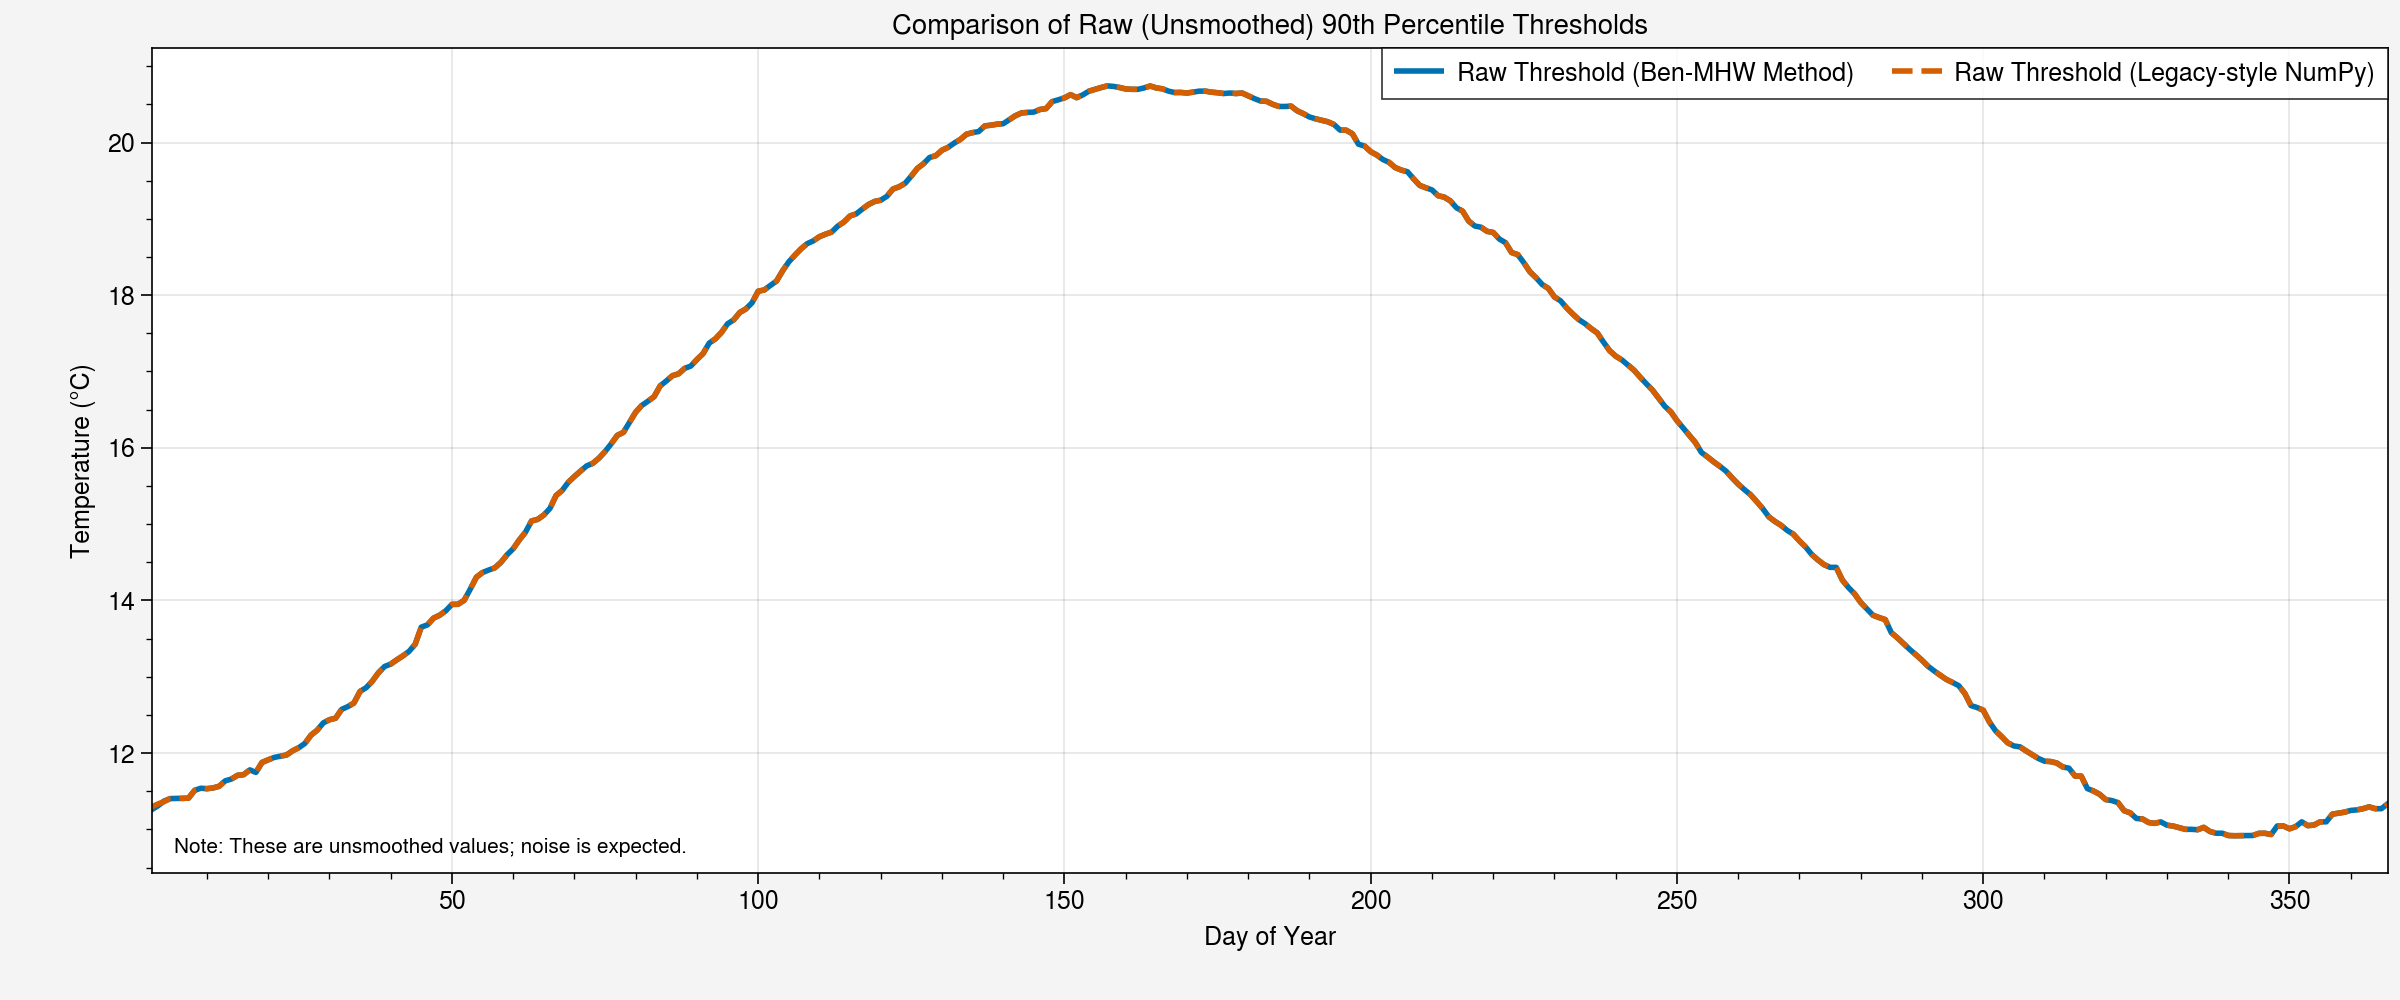

In [10]:
# --- Cell 7: Due Diligence - Raw (Unsmoothed) Threshold Analysis (Corrected) ---

print("Calculating RAW (unsmoothed) percentile values for each day-of-year...")

# We need the dayofyear array from our time coordinate for grouping
doy = ds_for_clim.time.dt.dayofyear

# --- Method 1: Replicate your ben-mhw logic (using xarray) ---
raw_actual_thresh = []
for day in range(1, 367):
    if day <= 366 - 5:
        window = ds_for_clim.temp.where((doy >= day - 5) & (doy <= day + 5), drop=True)
    else:
        window = ds_for_clim.temp.where((doy >= day - 5) | (doy <= (day + 5) % 366), drop=True)
    
    percentile_val = window.quantile(0.9, dim='time', skipna=False)
    raw_actual_thresh.append(percentile_val.item())

# --- Method 2: Replicate the legacy logic (using basic NumPy) ---
raw_expected_thresh = []
temp_np = ds_for_clim.temp.values.flatten()
doy_np = doy.values

for day in range(1, 367):
    days_in_window = np.arange(day - 5, day + 6)
    days_in_window[days_in_window < 1] += 366
    days_in_window[days_in_window > 366] -= 366
    
    indices_in_window = np.isin(doy_np, days_in_window)
    percentile_val = np.percentile(temp_np[indices_in_window], 90)
    raw_expected_thresh.append(percentile_val)

print("Raw value calculation complete.")

# --- Create the comparison plot ---
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

day_of_year_axis = np.arange(1, 367)
ax.plot(day_of_year_axis, raw_actual_thresh, lw=2, label='Raw Threshold (Ben-MHW Method)')
ax.plot(day_of_year_axis, raw_expected_thresh, lw=2, linestyle='--', label='Raw Threshold (Legacy-style NumPy)')
ax.plot([], [], lw=0)

# The proplot equivalent of 'axes fraction' is just 'axes'
ax.text(0.01, 0.02, 'Note: These are unsmoothed values; noise is expected.', transform='axes', ha='left', va='bottom', fontsize='small') # <--- THIS IS THE CORRECTED LINE

ax.format(
    title='Comparison of Raw (Unsmoothed) 90th Percentile Thresholds',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
uplt.show()